  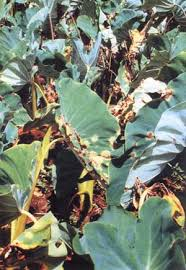


In [ ]:
pip install tensorflow_datasets

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import urllib


AUTOTUNE = tf.data.experimental.AUTOTUNE




import tensorflow_datasets as tfds
import PIL.Image
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)
import numpy as np






# Any results you write to the current directory are saved as output.

In [ ]:

IMAGE_PATH = "../input/plant-pathology-2020-fgvc7/images/"
TEST_PATH = "../input/plant-pathology-2020-fgvc7/test.csv"
TRAIN_PATH = "../input/plant-pathology-2020-fgvc7/train.csv"
SUB_PATH = "../input/plant-pathology-2020-fgvc7/sample_submission.csv"

sub = pd.read_csv(SUB_PATH)
test_data = pd.read_csv(TEST_PATH)
plant_data = pd.read_csv(TRAIN_PATH)

Here iam using a pretrained model (Mobilenet ) with fine tunning:

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.


**Feature Extraction:** Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

**Fine-Tuning**: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task

*Healthy plant leaf*


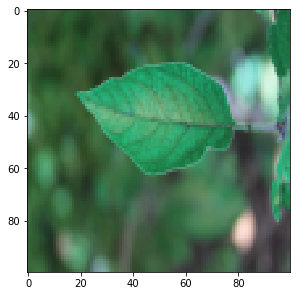    





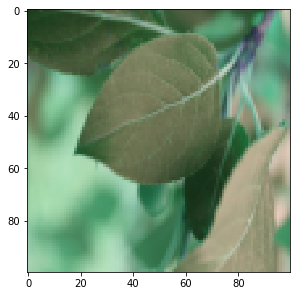

**Leaf which having multiple disease**


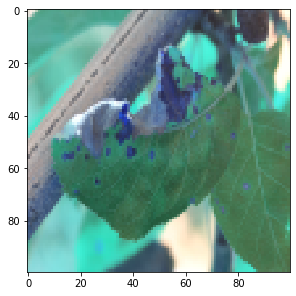

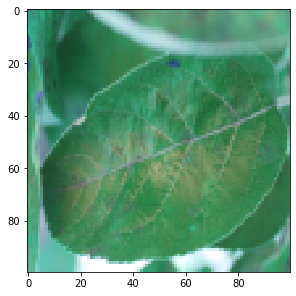

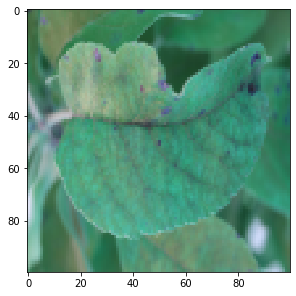

**Leaf  having rust**

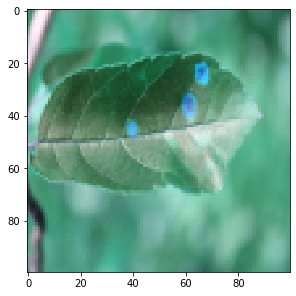

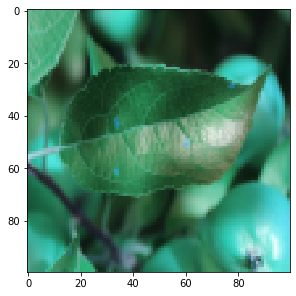

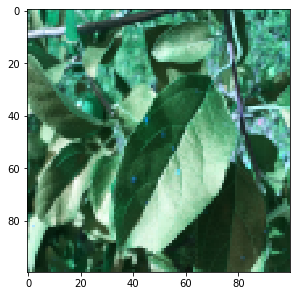

**Leaf which scab**
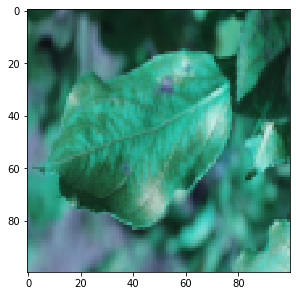


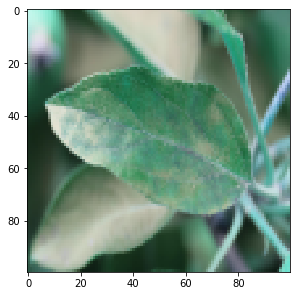

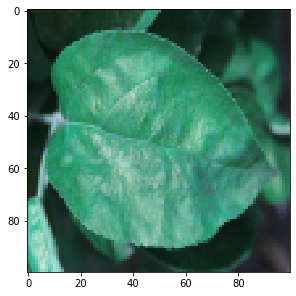

In [ ]:

def format_path(st):
    return IMAGE_PATH + st+'.jpg'

#taking the file path of train and test images
train_paths = plant_data.image_id.apply(format_path).values
test_paths =test_data.image_id.apply(format_path).values

#Taking  the labels of train images
labels = np.float32(plant_data.loc[:, 'healthy':'scab'].values)

#splitting int train and validation 
train_path,val_path,train_lab,val_label=train_test_split(train_paths,labels, test_size=0.3, random_state=42)

In [ ]:
IMG_SIZE = 160 # All images will be resized to 160x160
#Resize the images to a fixed input size, and rescale the input channels to a range of [-1,1]
def aug_format_example(image, label=None):
    
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = (image/255) 
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

   
   
    if label is None :
        return image
    else:
        return image, label

def format_example(image, label=None):
    
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = (image/255) 
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    if label is None :
        return image
    else:
        return image, label


In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 500
#Apply this function to each item in the dataset using the map method:
train = tf.data.Dataset.from_tensor_slices((train_path, train_lab)).map(aug_format_example)
val=tf.data.Dataset.from_tensor_slices((val_path, val_label)).map(format_example)
test=tf.data.Dataset.from_tensor_slices((test_paths)).map(format_example)

**Label Distributions**



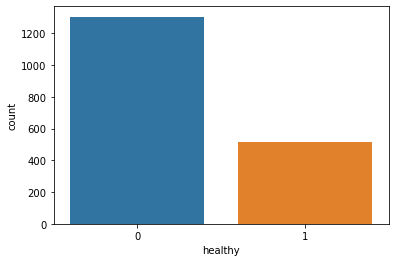

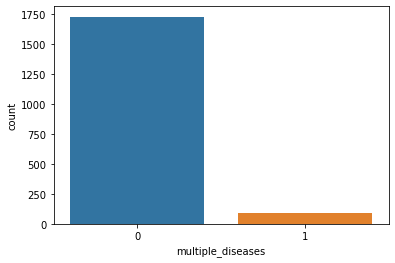

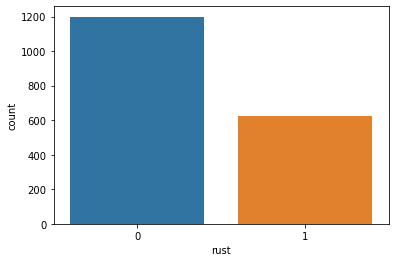

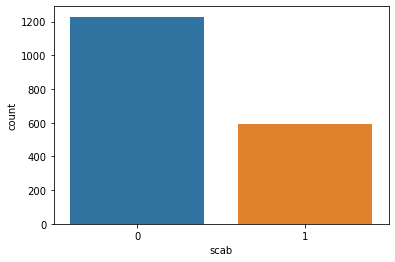

In [ ]:
#Now shuffle and batch the data.
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches =val.batch(BATCH_SIZE)
test_batches=test.batch(BATCH_SIZE)

In [ ]:
#Inspect a batch of data:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
IMG_SIZE=160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model =tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


1. This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. See what it does to the example batch of images:

In [ ]:

feature_batch = base_model(image_batch)
print(feature_batch.shape)

Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

Freeze the convolutional base
It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all the layers.

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

In [ ]:
prediction_layer = tf.keras.layers.Dense(4,activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

In [ ]:
model = tf.keras.models.Sequential([base_model,
                                 global_average_layer ,
                            prediction_layer,
                                ])

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)

In [ ]:
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
# Define the checkpoint directory to store the checkpoints

checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [ ]:
def decay(epochs):
    if epochs < 3:
        return 1e-3
    elif epochs >= 3 and epochs < 7:
        return 1e-4
    else:
        return 1e-5

In [ ]:
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

In [ ]:
callbacks = [
    
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [ ]:

STEPS_PER_EPOCH = labels.shape[0] // BATCH_SIZE
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    callbacks=callbacks,
              
                    validation_data=validation_batches)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **Fine tuning**
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.


Un-freeze the top layers of the model
All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:

model.compile(optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
               loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                          callbacks=callbacks,
                      
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

To understand how my model working on Validation Data

In [ ]:

x_val=[]
y_val=[]
for image_batch, label_batch in validation_batches.take(1):
    x_val.append(image_batch)
    y_val.append(label_batch)
y_val=np.array(y_val).reshape(32,4)    
  

In [ ]:
#predicting on validation input
c=x_val
Y_pred = model.predict(c)

Y_pred


In [ ]:
for row in range(len(Y_pred)):
    for col in range(4):
        if Y_pred[row][col] == max(Y_pred[row]):
            Y_pred[row][col] = 1
        else:
            Y_pred[row][col] = 0


In [ ]:
#funtion to create confition _matrix
import sklearn
import itertools
from sklearn.metrics import confusion_matrix
dict_characters = {0: 'No', 1: 'Yes'}
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#Y_pred_classes = np.argmax(y_p,axis=0) 
confusion_mtx = confusion_matrix(y_val[:,0],np.array(Y_pred)[:,0]) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values()))

In [ ]:
#Y_pred_classes = np.argmax(y_p,axis=0) 
confusion_mtx = confusion_matrix(y_val[:,1],np.array(Y_pred)[:,1]) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values()))

In [ ]:
#Y_pred_classes = np.argmax(y_p,axis=0) 
confusion_mtx = confusion_matrix(y_val[:,2],np.array(Y_pred)[:,2]) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values()))

In [ ]:
#Y_pred_classes = np.argmax(y_p,axis=0) 
confusion_mtx = confusion_matrix(y_val[:,3],np.array(Y_pred)[:,3]) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values()))

In [ ]:
t=test_batches
Y_pred1 = model.predict(t)

Y_pred1




In [ ]:
Y_pred1=pd.DataFrame(Y_pred1 ,columns=['healthy',	'multiple_diseases','rust','scab'])
Y_pred1.to_csv('submission1.csv')